# Imports

In [4]:
!pip install "gymnasium[atari, accept-rom-license]"

  Using cached gymnasium-0.29.1-py3-none-any.whl.metadata (10 kB)
  Using cached cloudpickle-3.0.0-py3-none-any.whl.metadata (7.0 kB)
  Using cached Farama_Notifications-0.0.4-py3-none-any.whl.metadata (558 bytes)
  Using cached AutoROM-0.4.2-py3-none-any.whl.metadata (2.8 kB)
  Using cached Shimmy-0.2.1-py3-none-any.whl.metadata (2.3 kB)
  Using cached click-8.1.7-py3-none-any.whl.metadata (3.0 kB)
  Using cached AutoROM.accept_rom_license-0.6.1-py3-none-any.whl
  Using cached ale_py-0.8.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (8.1 kB)
  Using cached importlib_resources-6.4.0-py3-none-any.whl.metadata (3.9 kB)
Using cached AutoROM-0.4.2-py3-none-any.whl (16 kB)
Using cached cloudpickle-3.0.0-py3-none-any.whl (20 kB)
Using cached Farama_Notifications-0.0.4-py3-none-any.whl (2.5 kB)
Using cached Shimmy-0.2.1-py3-none-any.whl (25 kB)
Using cached gymnasium-0.29.1-py3-none-any.whl (953 kB)
Using cached ale_py-0.8.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2

In [2]:
!pip install "gymnasium[atari, accept-rom-license]"
!pip install moviepy
!pip install matplotlib
!pip install install tensorflow[and-cuda]

  Using cached gymnasium-0.29.1-py3-none-any.whl.metadata (10 kB)
  Using cached cloudpickle-3.0.0-py3-none-any.whl.metadata (7.0 kB)
  Using cached Farama_Notifications-0.0.4-py3-none-any.whl.metadata (558 bytes)
  Using cached AutoROM-0.4.2-py3-none-any.whl.metadata (2.8 kB)
  Using cached Shimmy-0.2.1-py3-none-any.whl.metadata (2.3 kB)
  Using cached box2d-py-2.3.5.tar.gz (374 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pygame-2.5.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (13 kB)
  Using cached swig-4.2.1-py2.py3-none-manylinux_2_5_x86_64.manylinux1_x86_64.whl.metadata (3.6 kB)
  Using cached click-8.1.7-py3-none-any.whl.metadata (3.0 kB)
  Using cached AutoROM.accept_rom_license-0.6.1-py3-none-any.whl
  Using cached ale_py-0.8.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (8.1 kB)

In [1]:
import numpy as np
import gymnasium as gym
import tensorflow as tf
import tqdm.notebook as tqdm
import matplotlib.pyplot as plt
from tensorflow.keras.regularizers import l2

2024-05-02 14:06:39.715714: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-02 14:06:40.594671: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
              tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

2024-05-02 14:06:41.720400: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2024-05-02 14:06:41.720448: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:134] retrieving CUDA diagnostic information for host: mimisha-laptop
2024-05-02 14:06:41.720455: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:141] hostname: mimisha-laptop
2024-05-02 14:06:41.720542: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:165] libcuda reported version is: 550.76.0
2024-05-02 14:06:41.720562: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:169] kernel reported version is: 550.76.0
2024-05-02 14:06:41.720568: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:248] kernel version seems to match DSO: 550.76.0


# Environment

Create the environment. You can use any ATARI environment from [here](https://gymnasium.farama.org/environments/atari/), but prefer to use environments with discrete action space with fewer actions.

A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]
/home/mimisha/.pyenv/versions/atari-venv/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:335: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(


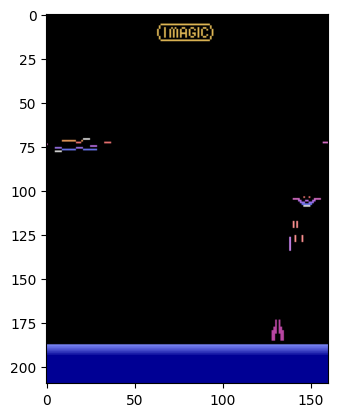

In [3]:
env = gym.make('ALE/DemonAttack-v5', render_mode='rgb_array')
eval_env = gym.make('ALE/DemonAttack-v5')
env.reset()
plt.imshow(env.render())

In [4]:
env.action_space.__dict__.keys()

dict_keys(['n', 'start', '_shape', 'dtype', '_np_random'])

In [5]:
(60, *env.observation_space._shape)

(60, 210, 160, 3)

# Replay Buffer

Create a replay buffer to hold game history

In [6]:
class ReplayBuffer:

    def __init__(self, max_size: int, observation_space: gym.spaces.Space, action_space: gym.spaces.Space, seed: int | None = None):
        """Stores the replay history with a maximum of `max_size` entries, removing old entries as needed.

        Parameters:
            max_size: maximal number of entries to keep
            observation_space: specification of the observation space
            action_space: specification of the action space
            seed: seed to initialize the internal random number generator for reproducibility"""
        self.max_size = max_size
        self.observation_space = observation_space
        self.action_space = action_space
        self.seed = seed
        self.rng = np.random.default_rng(seed=seed)
        
        self.current_state = np.zeros((max_size, *observation_space.shape))
        
        self.action = np.zeros(max_size, dtype=int)
        self.reward = np.zeros(max_size)
        self.next_state = np.zeros_like(self.current_state)
        self.done = np.zeros(max_size)
        
        self.step = 0
        self.len = 0
        
    def add(self, current_observation: np.ndarray, action: int, reward: float, next_observation: np.ndarray, done: bool) -> None:
        """Add a new entry to the buffer.

        Parameters:
            current_observation: environment state observed at the current step
            action: action taken by the model
            reward: reward received after taking the action
            next_observation: environment state obversed after taking the action
            done: whether the episode has ended or not"""
        self.current_state[self.step] = current_observation
        self.action[self.step] = action
        self.reward[self.step] = reward
        self.next_state[self.step] = next_observation
        self.done[self.step] = done
        self.step = (self.step + 1) % self.max_size
        self.len = min(self.len + 1, self.max_size)
        
    def sample(self, n_samples: int, replace: bool = True) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
        """Randomly samples `n_samples` from the buffer.

        Parameters:
            n_samples: number of samples to select
            replace: sample with or without replacement

        Returns:
            current observations, actions, rewards, next observations, done"""
        indicies = self.rng.choice(self.len, size=n_samples)
        return (
            self.current_state[indicies], 
            self.action[indicies], 
            self.reward[indicies], 
            self.next_state[indicies], 
            self.done[indicies]
        )

    def clear(self) -> None:
        """Clears the buffer"""
        self.step = self.len = 0

    def __getitem__(self, index: int) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
        """Gets a sample at `index`

        Parameters:
            index: index of the sample to get

        Returns:
            current observation, action, reward, next observation, done"""
        return (
            self.current_state[index], 
            self.action[index], 
            self.reward[index], 
            self.next_state[index], 
            self.done[index]
        )
        
    def __len__(self) -> int:
        """Returns the number of entries in the buffer"""
        return self.len

# Model

Implement your model. Most if not all ATARI environments have an image observation

In [7]:
def get_name(prefix: str | None = None, suffix: str | None = None, separator: str = '_') -> str | None:
    if prefix is None:
        return suffix
    return prefix and prefix + separator + suffix or suffix or None

In [8]:
def convBlock(filters: int, filter_size: int, inputs, number: int):
    local = tf.keras.layers.Conv2D(filters, filter_size, padding="same", kernel_initializer="he_normal", 
                                           kernel_regularizer=l2(1e-4), name=get_name(suffix=f'conv_bloc_{number}'))(inputs)
    local = tf.keras.layers.PReLU()(local)
    local = tf.keras.layers.BatchNormalization()(local)
    return local

In [9]:
def get_model(
    input_features: tuple, 
    out_features: int,
    blocks: int, 
    activation: str | tf.keras.layers.Activation | None = 'silu',
    dropout: float = 0.,
    kernel_num: int = 8,
    multiply_freq: int = 2,
    name: str | None = None
) -> tf.keras.Model:
    inputs = x = tf.keras.layers.Input(input_features, name=get_name(name, 'input'))

    for i in range(blocks):
        # position, velocity, angle, angle velocity
        x = convBlock(kernel_num, 3, x, i)
        x = tf.keras.layers.MaxPooling2D()(x)
        if dropout > 0:
            x = tf.keras.layers.Dropout(dropout, name=get_name(name, f'dropout_{i}'))(x)

        if multiply_freq > 0 and (i + 1) % multiply_freq == 0:
            kernel_num *= 2

    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(out_features, name=get_name(name, 'prediction'))(x)
    
    return tf.keras.Model(inputs=inputs, outputs=x, name=name)

In [10]:
model = get_model(env.observation_space._shape, out_features=env.action_space.n, blocks=5, name="my_model", dropout=0.1, activation='swish', multiply_freq=2)
model.summary()
target_model = get_model(env.observation_space._shape, out_features=env.action_space.n, blocks=5, name="my_model", dropout=0.1, activation='swish', multiply_freq=2)

Model: "my_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ my_model_input (InputLayer)     │ (None, 210, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_bloc_0 (Conv2D)            │ (None, 210, 160, 8)    │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ p_re_lu (PReLU)                 │ (None, 210, 160, 8)    │       268,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 210, 160, 8)    │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 105, 80, 8)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ my_model_dropout_0 (Dropout)    │ (None, 105, 80, 8)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_bloc_1 (Conv2D)            │ (None, 105, 80, 8)     │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ p_re_lu_1 (PReLU)               │ (None, 105, 80, 8)     │        67,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 105, 80, 8)     │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 52, 40, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ my_model_dropout_1 (Dropout)    │ (None, 52, 40, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_bloc_2 (Conv2D)            │ (None, 52, 40, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ p_re_lu_2 (PReLU)               │ (None, 52, 40, 16)     │        33,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 40, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 20, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ my_model_dropout_2 (Dropout)    │ (None, 26, 20, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_bloc_3 (Conv2D)            │ (None, 26, 20, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ p_re_lu_3 (PReLU)               │ (None, 26, 20, 16)     │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 26, 20, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 13, 10, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ my_model_dropout_3 (Dropout)    │ (None, 13, 10, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_bloc_4 (Conv2D)            │ (None, 13, 10, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ p_re_lu_4 (PReLU)               │ (None, 13, 10, 32)     │         4,16

 Total params: 391,214 (1.49 MB)

 Trainable params: 391,054 (1.49 MB)

 Non-trainable params: 160 (640.00 B)

In [11]:
env.action_space.n

6

# Sampler

Implement the sampler

In [12]:
class Sampler:
    
    def __init__(self, epsilon: float, seed: int | None = None):
        """Selects a random action with probability `epsilon` otherwise selects the most probably action given by the model.

        Parameters:
            epsilon: the probability to select a random action
            seed: seed to initialize the internal random number generator for reproducibility"""
        self.rng = np.random.default_rng(seed=seed)
        self.epsilon = epsilon
        
    def __call__(self, probabilities: np.ndarray) -> int:
        """Select an action given the `probabilities

        Parameters:
            probabilities: probabilities for each action

        Returns:
            index of the selected action"""
        if self.rng.random() < self.epsilon:
            return self.rng.integers(probabilities.shape[0])
        return np.argmax(probabilities)

# Play the game

Implement interacting with the environment and storing entries to the replay buffer

In [13]:
def play_game(model: tf.keras.Model, buffer: ReplayBuffer | None, env: gym.Env, max_steps: int, sampler: Sampler, observation: np.ndarray | None = None, isEvaluate: bool = False) -> np.ndarray:
    """Play game and record

    Parameters:
        model: the model to get actions with
        buffer: replay buffer to store the entries to
        env: environment to play
        max_steps: maximal number of steps to perform
        sampler: sampler to use to sample actions
        observation: the observation to resume from

    Returns:
        the last observation"""
    if observation is None:
        observation, _ = env.reset()

    buffer = buffer if buffer is not None else ReplayBuffer(1) # cannot do or

    for i in range(max_steps):
        a = sampler(model(observation[None], training=False).numpy()[0])
        n_observations, score, done, terminated, _ = env.step(a)
        buffer.add(observation, a, score, n_observations, done)
        if done or terminated:
            if isEvaluate:
                return
            observation, _ = env.reset()
            continue
        observation = n_observations
    return observation

# Loss

Implement double q learning loss

In [14]:
def qq_loss(
    current_observation: tf.Tensor, 
    action: tf.Tensor, 
    reward: tf.Tensor, 
    next_observation: tf.Tensor, 
    done: tf.Tensor,
    model: tf.keras.Model,
    target_model: tf.keras.Model,
    gamma: float
) -> tf.Tensor:
    """Computes double q learning loss.

    Parameters:
        current_observation: observations at the current time step
        action: actions taken at the current time step
        reward: rewards at the current time step
        next_observation: observations at the next time step
        done: whether the episode has ended or not
        model: trainig model
        target_model: target model
        gamme: discount

    Returns:
        Computed loss"""
    q_current = model(current_observation)
    q_next = target_model(next_observation)

    a_next = tf.argmax(model(next_observation), axis=-1)
    
    # q_ref = tf.stop_gradient(reward + gamma * tf.reshape(tf.gather(q_next, tf.expand_dims(a_next, axis=-1), batch_dims=1), (-1, )) * (1. - done))
    q_ref = reward + gamma * tf.reshape(tf.gather(q_next, tf.expand_dims(a_next, axis=-1), batch_dims=1), (-1, )) * (1. - done)
    
    q = tf.reshape(tf.gather(q_current, tf.expand_dims(action, axis=-1), batch_dims=1), (-1, ))

    return tf.math.reduce_mean(tf.square(q_ref - q))

# Training

Create models, replay buffers, sampler, optimizer, epsilon decay etc. Implement training loop, show training progress and perform model evaluation once in a while

In [15]:
target_model.trainable = False
target_model.set_weights(model.get_weights())

In [16]:
train_buffer = ReplayBuffer(100, observation_space=env.observation_space, action_space=env.action_space)
train_sampler = Sampler(1)

In [17]:
eval_buffer = ReplayBuffer(100, observation_space=env.observation_space, action_space=env.action_space)
eval_sampler = Sampler(0)

In [18]:
optimizer = tf.keras.optimizers.Adam(1e-4, clipnorm=5, weight_decay=2e-5)

In [19]:
epochs = 20 ** 3
batch_size = 16
decay_epochs = epochs // 2
end_epsilon = 0.1
update_frequency = 225
eval_frequency = 225
steps_per_epoch = 16
eval_steps = 100
initial_samples = 1000
n_evals = 5
eval_threshold = 200

In [20]:
epsilon_decay = tf.keras.optimizers.schedules.PolynomialDecay(1., decay_epochs, end_learning_rate=end_epsilon)

In [21]:
losses = []
total_loss = 0
eval_score = 0

model.save_weights('test.weights.h5')
s, _ = env.reset()
pbar = tqdm.trange(epochs)
for i in pbar:
    print(f'{i} iteration')
    train_sampler.epsilon = epsilon_decay(i).numpy()
    
    s = play_game(model, train_buffer, env, steps_per_epoch, train_sampler, observation=s)

    model_weights = [v.value for v in model.trainable_weights]
    
    vals = train_buffer.sample(batch_size)
    with tf.GradientTape(watch_accessed_variables=False) as g:
        g.watch(model_weights)
        loss = qq_loss(*vals, model, target_model, 0.99)

    gradient = g.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(gradient, model.trainable_weights))
    
    losses.append(loss.numpy())
    total_loss += losses[-1]

    if (i + 1) % update_frequency == 0:
        target_model.set_weights(model.get_weights())

    if (i + 1) % eval_frequency == 0:
        eval_score = 0

        for i in range(n_evals):
            eval_buffer.clear()
            play_game(model, eval_buffer, eval_env, eval_steps, eval_sampler, isEvaluate=True)
            eval_score += eval_buffer.reward[:len(eval_buffer)].sum()

        eval_score /= n_evals
        if eval_score >= eval_threshold:
            break

    pbar.set_description(f'L: {losses[-1]:.5f}; AL: {total_loss / (i + 1):.5f}; E: {eval_score:.5f}')
model.save('result_checkpoint.keras')

  0%|          | 0/8000 [00:00<?, ?it/s]

0 iteration
1 iteration
2 iteration


KeyboardInterrupt: 

# Testing

Test the model on the environment and get a cool video

In [39]:
result_model = tf.keras.models.load_model('result_checkpoint.keras')

In [40]:
from gymnasium.utils.save_video import save_video
def save_gameplay(model: tf.keras.Model, render_mode: str = 'rgb_array_list'):
    env = gym.make('ALE/DemonAttack-v5', render_mode=render_mode)
    buffer = ReplayBuffer(1000, env.observation_space, env.action_space)
    play_game(result_model, buffer, env, 1000, Sampler(0), isEvaluate=True)
    render = env.render()
    save_video(render, r'/home/mimisha/DVFU/atari/videos/', durations=[1] * len(render), fps=24)
    return render, buffer

In [41]:
a, b = save_gameplay(model)

Moviepy - Building video /home/mimisha/DVFU/atari/videos/rl-video-episode-0.mp4.
Moviepy - Writing video /home/mimisha/DVFU/atari/videos/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /home/mimisha/DVFU/atari/videos/rl-video-episode-0.mp4


In [ ]:
b.reward.sum()